In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from src import Solver, RandomWalk, WeightedRandomJumps, bit_random_state, uniform_random_states, heuristic_states

# Example

In [2]:
populations = np.random.random(100)
positions = np.random.random((100, 2))

distance_matrix = np.zeros((100, 100), dtype=np.float32)
for i in range(100):
    for j in range(i, 100):
        distance_matrix[i, j] = distance_matrix[j, i] = np.sum((positions[i] - positions[j]) ** 2) ** 0.5

In [3]:
solver = Solver(populations, distance_matrix, RandomWalk)
solver.simulate_chains(1, 100, 10_000)["best_score"]

-6.096413691368861

# Example 2

In [4]:
solver = Solver(populations, distance_matrix, RandomWalk)
n_cities = 100
states = heuristic_states(n_cities, n_cities) # Special case because we start at different city each chain
solver.simulate_chains(1, 100, 10_000, states=states)["best_score"]

3.025854324258323

In [129]:
from tqdm.auto import tqdm
lambdas = np.linspace(0.01, 1.5, 100)
n_cities = 100
n_steps = 1000
n_iter = 100
states = heuristic_states(n_cities, n_cities) # Special case because we start at different city each chain

lambdas_to_df =[]
scores_to_df = []
nb_states_to_df = []
populations_to_df = []

for lambdate in tqdm(lambdas):
    for _ in range(n_iter):
        populations = np.random.random(100)
        positions = np.random.random((100, 2))
        distance_matrix = np.zeros((100, 100), dtype=np.float32)
        for i in range(100):
            for j in range(i, 100):
                distance_matrix[i, j] = distance_matrix[j, i] = np.sum((positions[i] - positions[j]) ** 2) ** 0.5
        solver = Solver(populations, distance_matrix, RandomWalk)
        res = solver.simulate_chains(lambda_= lambdate, n_chains=100, steps= n_steps, states=states)

        lambdas_to_df.append(lambdate)
        scores_to_df.append(res["best_score"])
        nb_states_to_df.append(res["best_state"].sum())
        populations_to_df.append(populations[res["best_state"]].sum())
    print(lambdate)

lambdas_res_df = pd.DataFrame({"lambda": lambdas_to_df, "score": scores_to_df, "nb_states": nb_states_to_df, "populations": populations_to_df})
#sabe to csv
lambdas_res_df.to_csv("lambdas_res_df.csv", index=False)


  0%|          | 0/100 [00:00<?, ?it/s]

0.01


KeyboardInterrupt: 

# Scores plors

  0%|          | 0/9 [00:00<?, ?it/s]

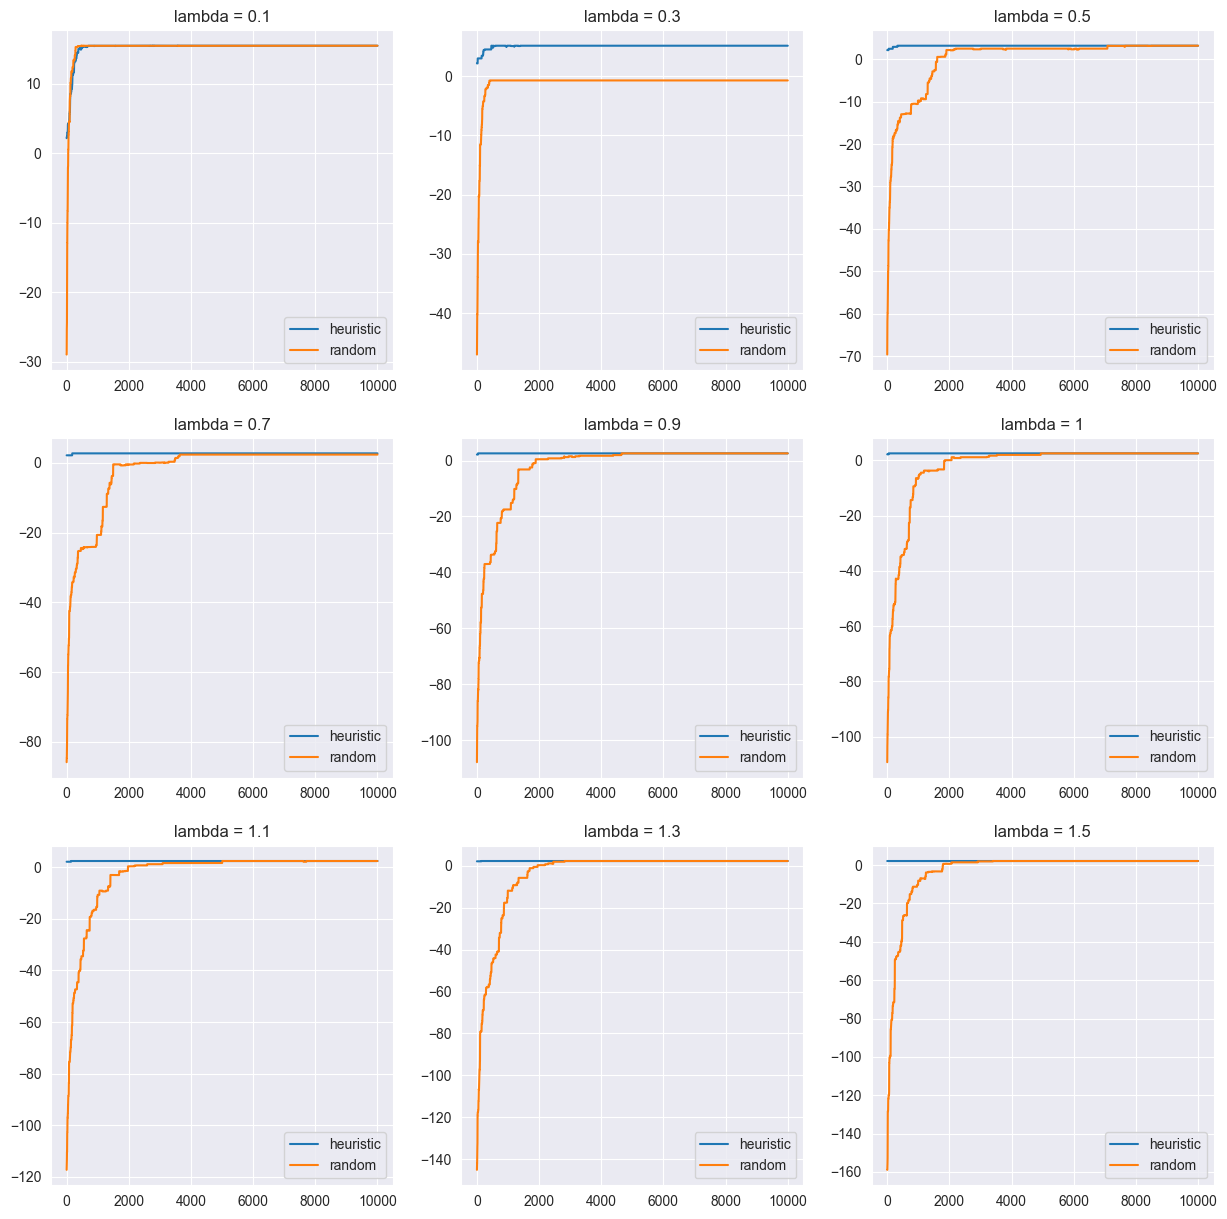

In [12]:
from tqdm.auto import tqdm
lambdas = [0.1, 0.3, 0.5, 0.7, 0.9, 1,  1.1, 1.3, 1.5]
n_cities = 100
n_steps = 10_000
states = heuristic_states(n_cities, n_cities) # Special case because we start at different city each chain
positions = np.random.random((100, 2))

#populations = np.random.random(100)
populations = np.random.normal(-0.85, 1.3, 100)

distance_matrix = np.zeros((100, 100), dtype=np.float32)
for i in range(100):
    for j in range(i, 100):
        distance_matrix[i, j] = distance_matrix[j, i] = np.sum((positions[i] - positions[j]) ** 2) ** 0.5


fix, ax = plt.subplots(3, 3, figsize=(15, 15))
i, j = 0, 0

for lambdate in tqdm(lambdas):
    solver = Solver(populations, distance_matrix, WeightedRandomJumps)
    res1 = solver.simulate_chains(lambdate, 100, n_steps, states=states, beta=10)
    res2 = solver.simulate_chains(lambdate, 100, n_steps, beta=10)
    ax[i, j].plot( np.linspace(0, n_steps, n_steps), res1["step_best_scores"],label="heuristic")
    ax[i, j].plot( np.linspace(0, n_steps, n_steps), res2["step_best_scores"], label="random")
    ax[i, j].set_title(f"lambda = {lambdate}")
    ax[i, j].legend()
    j += 1
    if j == 3:
        j = 0
        i += 1

plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

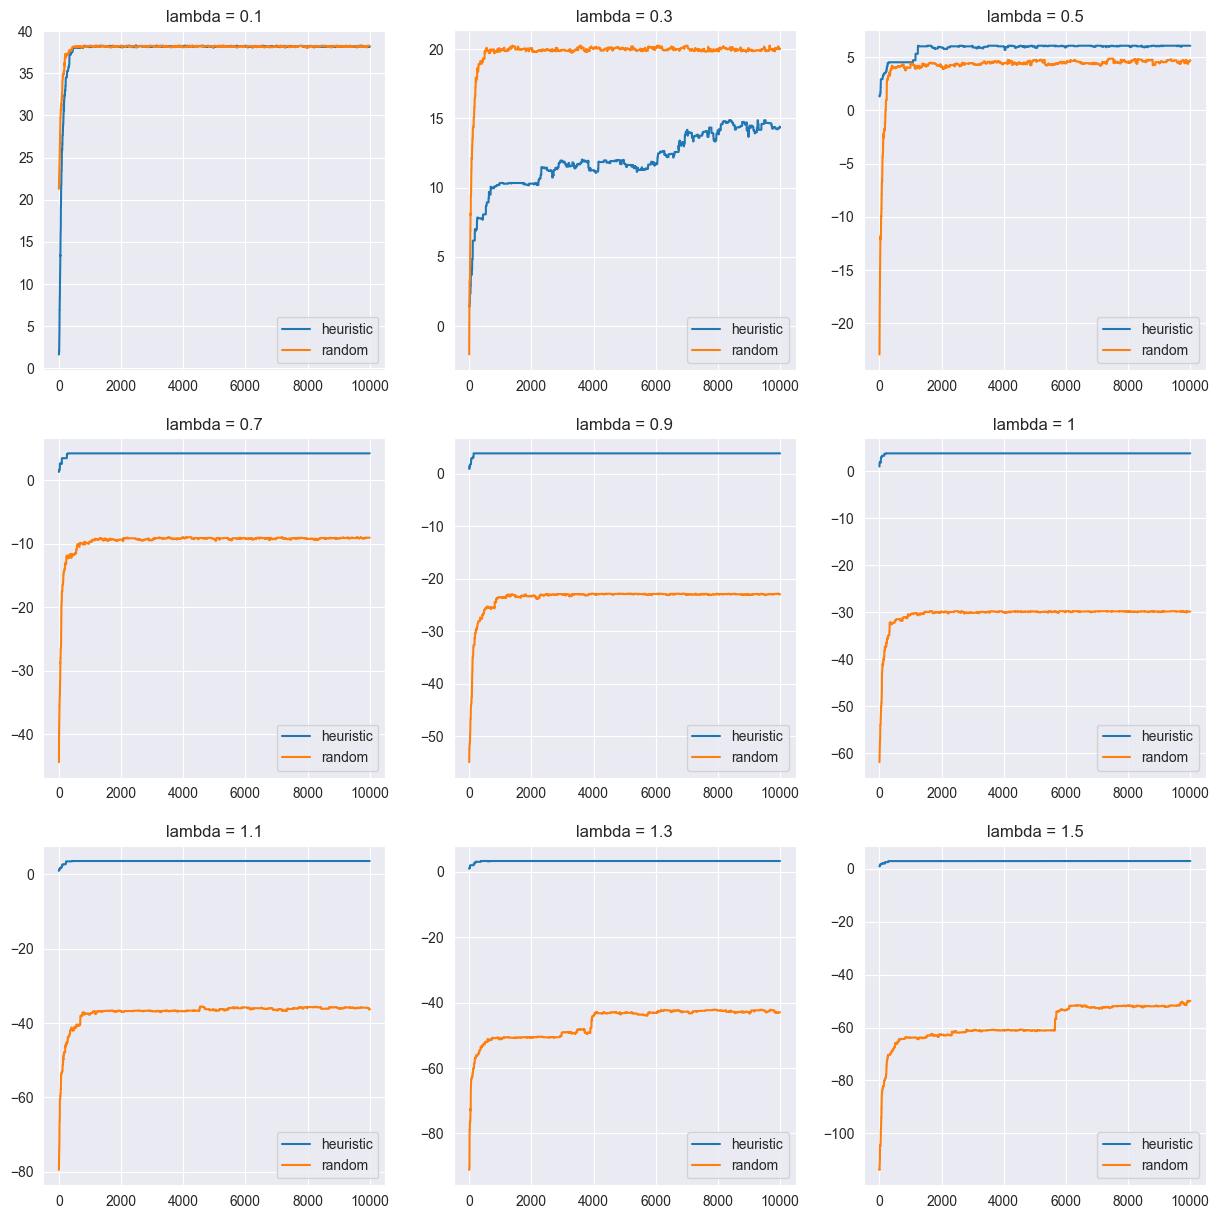

In [2]:
from tqdm.auto import tqdm
lambdas = [0.1, 0.3, 0.5, 0.7, 0.9, 1,  1.1, 1.3, 1.5]
n_cities = 100
n_steps = 10_000
states = heuristic_states(n_cities, n_cities) # Special case because we start at different city each chain
positions = np.random.random((100, 2))

populations = np.random.random(100)
#populations = np.random.normal(-0.85, 1.3, 100)

distance_matrix = np.zeros((100, 100), dtype=np.float32)
for i in range(100):
    for j in range(i, 100):
        distance_matrix[i, j] = distance_matrix[j, i] = np.sum((positions[i] - positions[j]) ** 2) ** 0.5


fix, ax = plt.subplots(3, 3, figsize=(15, 15))
i, j = 0, 0

for lambdate in tqdm(lambdas):
    solver = Solver(populations, distance_matrix, WeightedRandomJumps)
    res1 = solver.simulate_chains(lambdate, 100, n_steps, states=states, beta=10)
    res2 = solver.simulate_chains(lambdate, 100, n_steps, beta=10)
    ax[i, j].plot( np.linspace(0, n_steps, n_steps), res1["step_best_scores"],label="heuristic")
    ax[i, j].plot( np.linspace(0, n_steps, n_steps), res2["step_best_scores"], label="random")
    ax[i, j].set_title(f"lambda = {lambdate}")
    ax[i, j].legend()
    j += 1
    if j == 3:
        j = 0
        i += 1

plt.show()

# Step best sizes plots

  0%|          | 0/9 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Best city size per step')

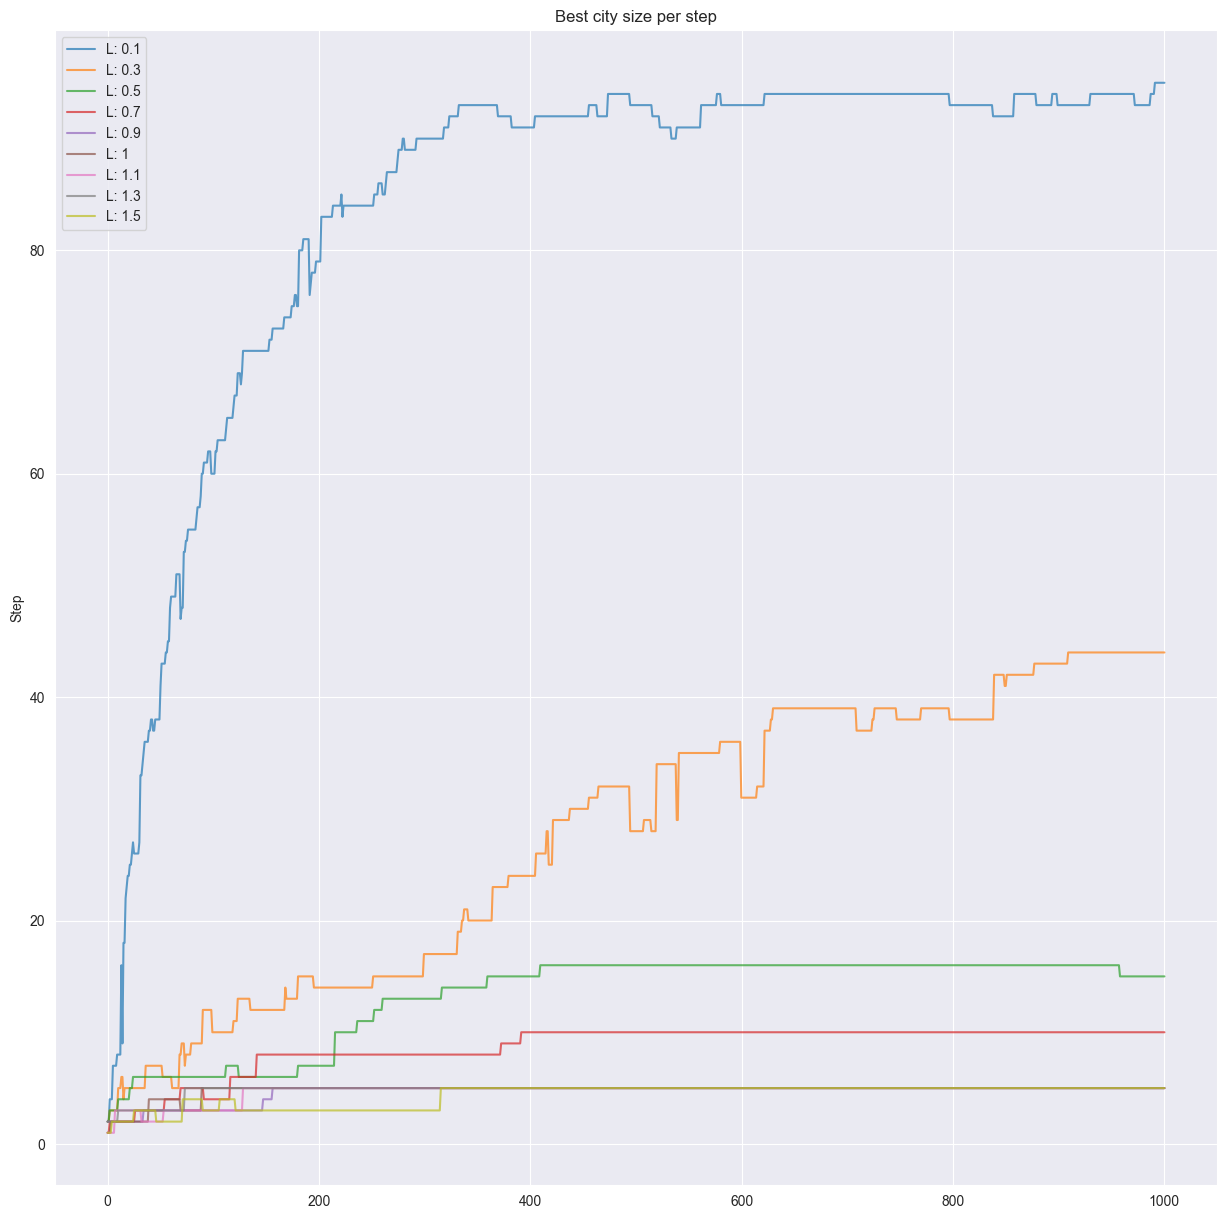

In [3]:
from tqdm.auto import tqdm
lambdas = [0.1, 0.3, 0.5, 0.7, 0.9, 1,  1.1, 1.3, 1.5]
n_cities = 100
n_steps = 10_00
states = heuristic_states(n_cities, n_cities) # Special case because we start at different city each chain
positions = np.random.random((100, 2))

populations = np.random.random(100)
#populations = np.random.normal(-0.85, 1.3, 100)

distance_matrix = np.zeros((100, 100), dtype=np.float32)
for i in range(100):
    for j in range(i, 100):
        distance_matrix[i, j] = distance_matrix[j, i] = np.sum((positions[i] - positions[j]) ** 2) ** 0.5


fix, ax = plt.subplots(figsize=(15, 15))
i, j = 0, 0

for lambdate in tqdm(lambdas):
    solver = Solver(populations, distance_matrix, WeightedRandomJumps)
    res1 = solver.simulate_chains(lambdate, 100, n_steps, states=states, beta=10)
    ax.plot( np.linspace(0, n_steps, n_steps), res1["step_best_state_size"],label=f"L: {lambdate}", alpha=0.7 )
ax.legend()
ax.yaxis.set_label_text("Size")
ax.yaxis.set_label_text("Step")
ax.set_title("Best city size per step")

  0%|          | 0/9 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Best city size per step')

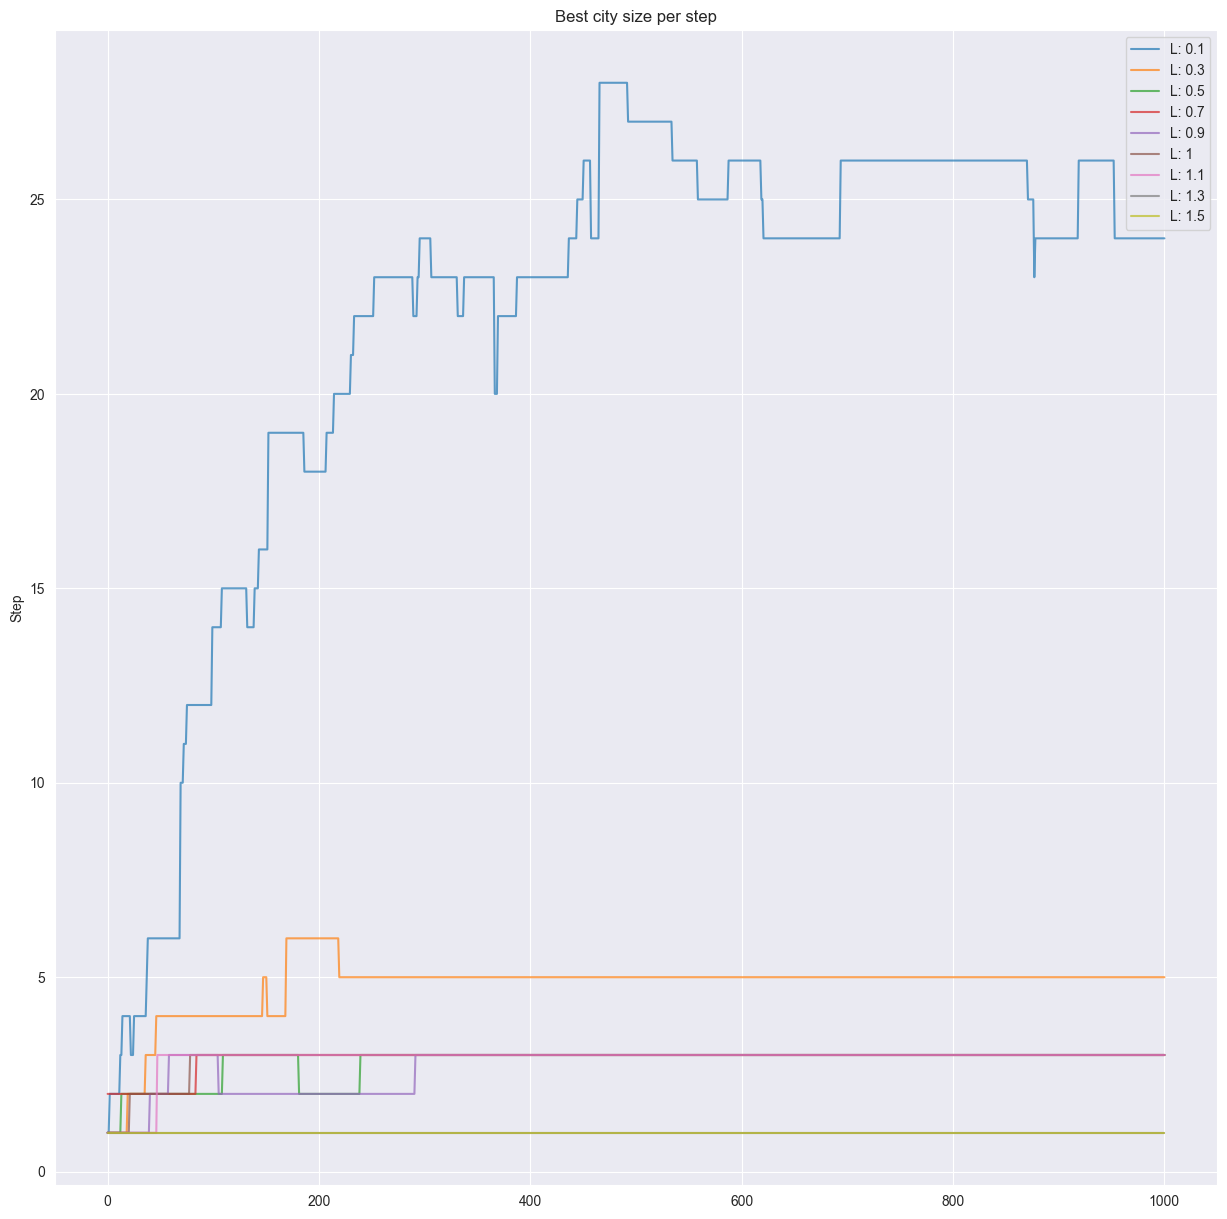

In [4]:
from tqdm.auto import tqdm
lambdas = [0.1, 0.3, 0.5, 0.7, 0.9, 1,  1.1, 1.3, 1.5]
n_cities = 100
n_steps = 10_00
states = heuristic_states(n_cities, n_cities) # Special case because we start at different city each chain
positions = np.random.random((100, 2))

#populations = np.random.random(100)
populations = np.random.normal(-0.85, 1.3, 100)

distance_matrix = np.zeros((100, 100), dtype=np.float32)
for i in range(100):
    for j in range(i, 100):
        distance_matrix[i, j] = distance_matrix[j, i] = np.sum((positions[i] - positions[j]) ** 2) ** 0.5


fix, ax = plt.subplots(figsize=(15, 15))
i, j = 0, 0

for lambdate in tqdm(lambdas):
    solver = Solver(populations, distance_matrix, WeightedRandomJumps)
    res1 = solver.simulate_chains(lambdate, 100, n_steps, states=states, beta=10)
    ax.plot( np.linspace(0, n_steps, n_steps), res1["step_best_state_size"],label=f"L: {lambdate}", alpha=0.7 )
ax.legend()
ax.yaxis.set_label_text("Size")
ax.yaxis.set_label_text("Step")
ax.set_title("Best city size per step")